### Import block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant

from sklearn.utils import class_weight

%matplotlib inline

In [2]:
# Check for available GPU.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Function definitions

In [3]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_input(path):
    # Load array.
    t_input = np.load(path)
    
    # Pad to even number of pixels
    #t_input = np.pad(t_input, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_input = tf.expand_dims(t_input, axis = -1)
    
    # Put channel dim at the end.
    t_input = np.moveaxis(t_input, 1, -1)
    
    return t_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    
    # Pad to even number of pixels
    #t_output = np.pad(t_output, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_output = tf.expand_dims(t_output, axis = -1)
    
    # Put channel dim at the end.
    t_output = np.moveaxis(t_output, 1, -1)
    return t_output

def data_generator(samples, batch_size = 64):
    
    while True:
        # Select files (paths/indices) for the batch
        batch_samples  = np.random.choice(a = samples.index, 
                                      size = batch_size)
        batch_input  = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for sample in batch_samples:
          input = get_input(samples.loc[sample].features)
          output = get_output(samples.loc[sample].labels)

          batch_input += [input]
          batch_output += [output]
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield(batch_x, batch_y)


In [4]:
m = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
m

,Unnamed: 0,Lon,Lat,Date,features,labels
0,424178,-53.777985,-6.178985,2018-09-16,Sample_CLSTM_Dataset/train/features/424178.npy,Sample_CLSTM_Dataset/train/labels/424178.npy
1,211198,-51.735630,-8.470318,2017-09-26,Sample_CLSTM_Dataset/train/features/211198.npy,Sample_CLSTM_Dataset/train/labels/211198.npy
2,197713,-50.511791,-9.797287,2017-09-20,Sample_CLSTM_Dataset/train/features/197713.npy,Sample_CLSTM_Dataset/train/labels/197713.npy
3,610851,-50.733681,-9.001179,2019-09-02,Sample_CLSTM_Dataset/train/features/610851.npy,Sample_CLSTM_Dataset/train/labels/610851.npy
4,164188,-57.372284,-6.126301,2017-09-14,Sample_CLSTM_Dataset/train/features/164188.npy,Sample_CLSTM_Dataset/train/labels/164188.npy
...,...,...,...,...,...,...
9889,152245,-50.735508,-7.020069,2017-09-13,Sample_CLSTM_Dataset/train/features/152245.npy,Sample_CLSTM_Dataset/train/labels/152245.npy
9890,423700,-51.096798,-6.575891,2018-09-16,Sample_CLSTM_Dataset/train/features/423700.npy,Sample_CLSTM_Dataset/train/labels/423700.npy
9891,190811,-56.483700,-7.026057,2017-09-19,Sample_CLSTM_Dataset/train/features/190811.npy,Sample_CLSTM_Dataset/train/labels/190811.npy
9892,135776,-51.519547,-9.694668,2017-09-10,Sample_CLSTM_Dataset/train/features/135776.npy,Sample_CLSTM_Dataset/train/labels/135776.npy


#### Load data

In [5]:
# Get data from one chip
sample_input = np.load('Sample_CLSTM_Dataset/train/features/119179.npy')

# Pad to even number of pixels
#a = np.pad(sample_input, [(0,0),(0,1),(0,1)])
# Resize to include a channel dimension.
#a = tf.expand_dims(a, axis = -1)
# Resize to include a batch dimension.
#a = tf.expand_dims(a, axis = 0)


# Move channel axis to the end
a = np.moveaxis(sample_input, 1, -1)

# Resize to include a batch dimension.
a = tf.expand_dims(a, axis = 0)

# Display shape for verification.
a.shape

TensorShape([1, 10, 32, 32, 2])

#### Model assumbly

In [6]:
# Inspired by: https://keras.io/examples/vision/conv_lstm/?fbclid=IwAR1QSJmF0bcz5pklHDHwl4mUi8inzHN4m8Zk6OpvVJizqDDv2-MKMq3LlJ8

inputs = layers.Input(shape=((10,32,32,2)))
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=False,
    activation='relu',
)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    activation='relu',
)(tf.expand_dims(x, axis = 1))
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=False,
    activation='relu',
)(tf.expand_dims(x, axis = 1))
outputs = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'
)(tf.expand_dims(x, axis = 1))

In [7]:
forecast_model = tf.keras.Model(inputs, outputs, name="Conv_LSTM")

In [8]:
# Verify output shape.
forecast_model.predict(a).shape

1/1 [==============================] - 2s 2s/step


(1, 1, 32, 32, 1)

In [9]:
# Display model details.
forecast_model.summary()

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 32, 32, 2)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 32, 32, 128)       1664512   
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 32, 32, 128)   0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 32, 32, 128)       1180160   
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                         

In [10]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
forecast_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])

In [11]:
# Data loaders.
batch_size = 64
meta_t = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
meta_v = pd.read_csv('Sample_CLSTM_Dataset/val/meta.csv')
t_gen = data_generator(meta_t, batch_size = batch_size)
v_gen = data_generator(meta_v, batch_size = batch_size)

In [12]:
# Trying new approach to build dataset.
x_train, y_train, x_val, y_val = [],[],[],[]

# Iterate over dataset.
for x in range(0,len(meta_t)):
    x_train.append(np.load(meta_t.iloc[x].features))
    y_train.append(np.load(meta_t.iloc[x].labels))
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features))
    y_val.append(np.load(meta_v.iloc[x].labels))
    
# Stack layers.
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)

# Convert values > 1 to 1.
x_train = np.minimum(x_train,1)
y_train = np.minimum(y_train,1)
x_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)

# Move channel dims to last.
x_train = np.moveaxis(x_train, 2, -1)
y_train = tf.expand_dims(y_train, axis = -1).numpy()
x_val = np.moveaxis(x_val, 2, -1)
y_val = tf.expand_dims(y_val, axis = -1).numpy()

In [13]:
# Experiment: modify output to single frame.
y_train = y_train[:,:1]
y_val = y_val[:,:1]

In [14]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((9894, 10, 32, 32, 2),
 (9894, 1, 32, 32, 1),
 (1902, 10, 32, 32, 2),
 (1902, 1, 32, 32, 1))

In [15]:
# Move numpy objects to tensors.
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)

In [16]:
# Params
batch_size = 8

# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

# Train model.
forecast_model.fit(x_train,
                   y_train,
                   epochs = 100, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = (x_val, y_val),
                   callbacks = [early_stopping, reduce_lr]
                  )

Epoch 1/100
1237/1237 [==============================] - 150s 118ms/step - loss: 0.0762 - accuracy: 0.9862 - val_loss: 0.0401 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 2/100
1237/1237 [==============================] - 144s 116ms/step - loss: 0.0556 - accuracy: 0.9869 - val_loss: 0.0410 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 3/100
1237/1237 [==============================] - 145s 118ms/step - loss: 0.0543 - accuracy: 0.9869 - val_loss: 0.0397 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 4/100
1237/1237 [==============================] - 144s 116ms/step - loss: 0.0537 - accuracy: 0.9869 - val_loss: 0.0398 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 5/100
1237/1237 [==============================] - 144s 116ms/step - loss: 0.0533 - accuracy: 0.9869 - val_loss: 0.0384 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 6/100
1237/1237 [==============================] - 144s 116ms/step - loss: 0.0529 - accuracy: 0.9869 - val_loss: 0.0375 - val_accuracy: 0.9916 - lr: 1.0000e-04
Epoc

In [17]:
# Save trained model.
forecast_model.save('Models/DU01')

INFO:tensorflow:Assets written to: Models/DU01\assets


INFO:tensorflow:Assets written to: Models/DU01\assets


In [18]:
forecast_model = tf.keras.models.load_model('Models/DU01')

### Examing single-frame predictions

In [29]:
# Select a random example from the validation dataset.
example = np.random.choice(range(len(x_val)), size=1)[0]

# Pick the first/last ten frames from the example.
feature_frames = x_val[example, ...]
label_frames = y_val[example, ...]
pred_frames = []

# Predict a new set of 10 frames.
# Extract the model's prediction and post-process it.
new_prediction = forecast_model.predict(np.expand_dims(feature_frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
pred_frames.append(predicted_frame)
    

# Extend the set of prediction frames.
pred_frames = np.concatenate(pred_frames)

1/1 [==============================] - 0s 24ms/step


In [22]:
# Shape verification.
label_frames.shape == pred_frames.shape

True

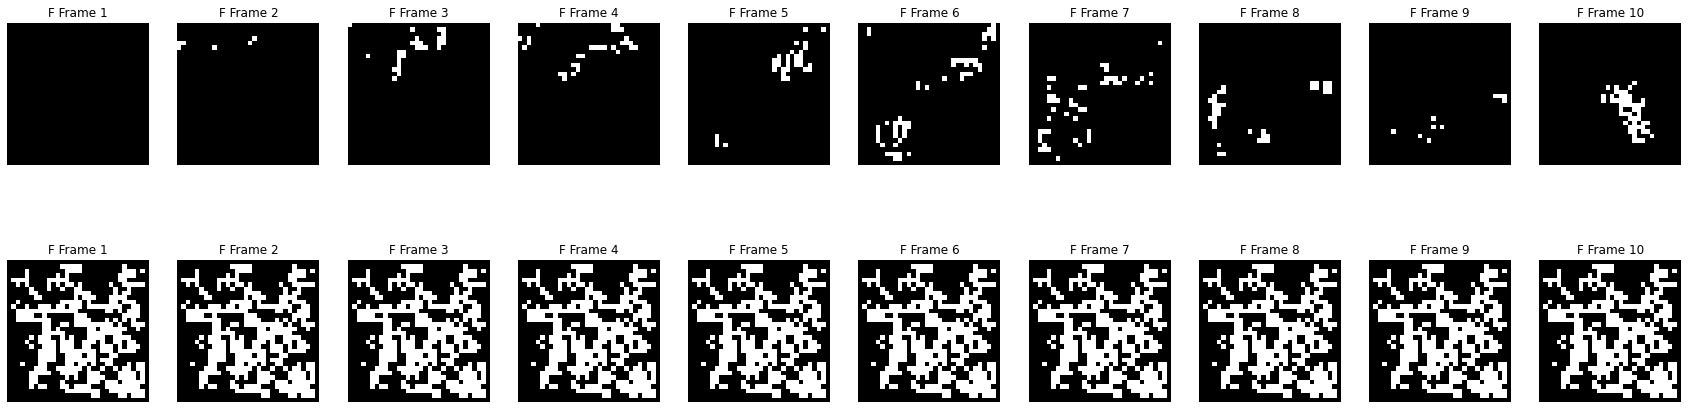

In [30]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,:1]), cmap="gray")
    ax.set_title(f"F Frame {idx + 1}")
    ax.axis("off")

# Plot the deforestation frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,1:2]), cmap="gray")
    ax.set_title(f"F Frame {idx + 1}")
    ax.axis("off")
    
# Display the figure.
plt.show()

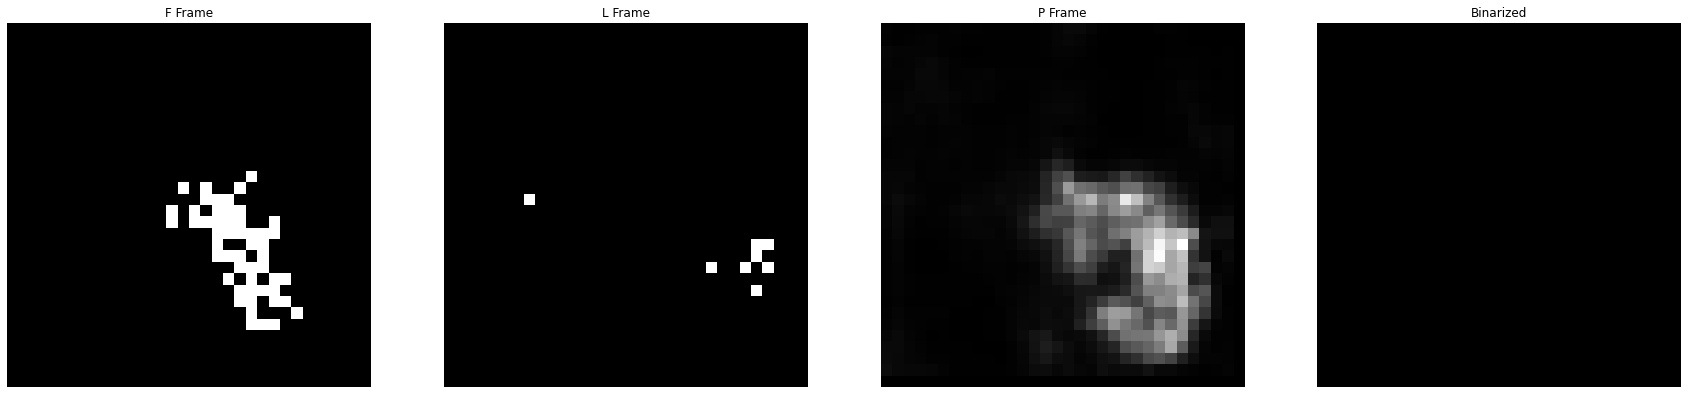

In [31]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 4, figsize=(30, 8))

# Plot the last feature frame.
axes[0].imshow(np.squeeze(feature_frames[9][:,:,:1]), cmap="gray")
axes[0].set_title(f"F Frame")
axes[0].axis("off")

# Plot the label frame.
axes[1].imshow(np.squeeze(label_frames[0]), cmap="gray")
axes[1].set_title(f"L Frame")
axes[1].axis("off")
    
# Plot the predicted frame.
axes[2].imshow(np.squeeze(pred_frames[0]), cmap="gray")
axes[2].set_title(f"P Frame")
axes[2].axis("off")

# Plot binarized prediction.
axes[3].imshow(np.squeeze(np.where(pred_frames > 0.85, 1, 0)), cmap="gray")
axes[3].set_title(f"Binarized")
axes[3].axis("off")

# Display the figure.
plt.show()

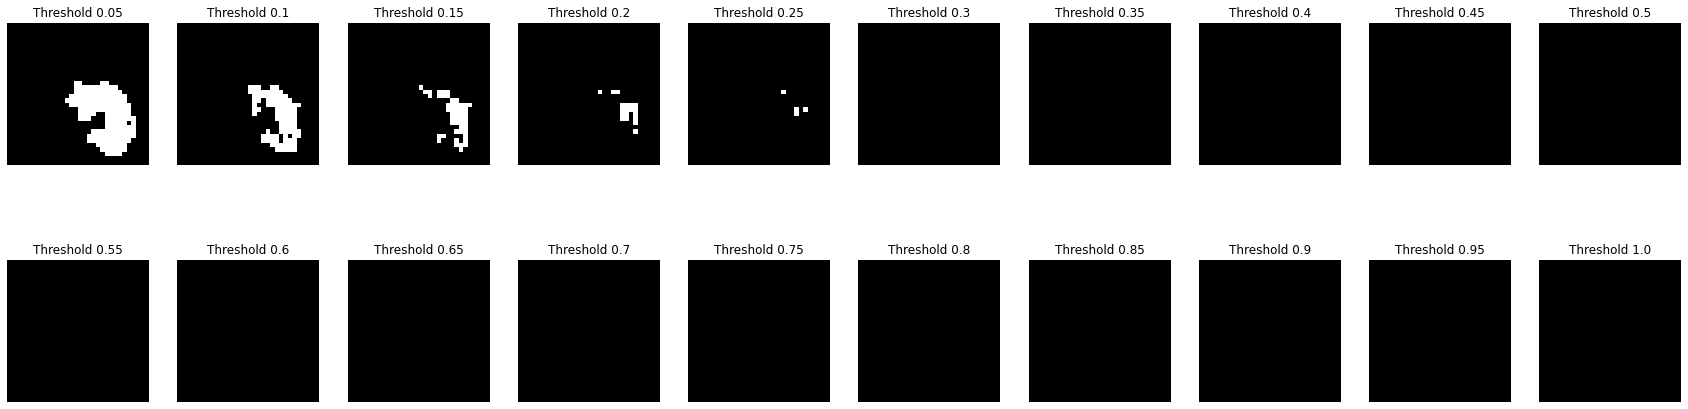

In [32]:
# Construct a figure to show all prediction thresholds.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 1) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 1) * 0.05, 2)}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 11) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 11) * 0.05, 2)}")
    ax.axis("off")
    
# Display the figure.
plt.show()

In [35]:
# Get first sample IoU
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(pred_frames > t, 1, 0), label_frames[0])
    union = np.logical_or(np.where(pred_frames > t, 1, 0), label_frames[0])
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.0078125),
 (0.05, 0.037267080745341616),
 (0.1, 0.019801980198019802),
 (0.15, 0.03571428571428571),
 (0.2, 0.08),
 (0.25, 0.0),
 (0.3, 0.0),
 (0.35, 0.0),
 (0.4, 0.0),
 (0.45, 0.0),
 (0.5, 0.0),
 (0.55, 0.0),
 (0.6, 0.0),
 (0.65, 0.0),
 (0.7, 0.0),
 (0.75, 0.0),
 (0.8, 0.0),
 (0.85, 0.0),
 (0.9, 0.0),
 (0.95, 0.0),
 (1.0, 0.0)]

### Get IoU for full prediction set.

In [36]:
# Predict on everything.
all_preds = forecast_model.predict(x_val)

60/60 [==============================] - 6s 91ms/step


In [37]:
# Get IoU.
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(all_preds > t, 1, 0), y_val)
    union = np.logical_or(np.where(all_preds > t, 1, 0), y_val)
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.008262786704784437),
 (0.05, 0.08102303261230982),
 (0.1, 0.10166452337396534),
 (0.15, 0.10100243013365735),
 (0.2, 0.08166014227385612),
 (0.25, 0.05793361667678608),
 (0.3, 0.03497438182223212),
 (0.35, 0.01944313909774436),
 (0.4, 0.008735465991927224),
 (0.45, 0.0038463886684168753),
 (0.5, 0.002338317641991262),
 (0.55, 0.001421332344580398),
 (0.6, 0.0009296560272699101),
 (0.65, 0.0002481697481077057),
 (0.7, 0.00012423903590508137),
 (0.75, 6.213495712687958e-05),
 (0.8, 0.0),
 (0.85, 0.0),
 (0.9, 0.0),
 (0.95, 0.0),
 (1.0, 0.0)]

In [38]:
# Get DataFrame of all prediction grades.
rows = []
for s in range(0,len(all_preds)): 
    thresholds = [x/100 for x in range(0,105,5)]
    ious = []
    for t in thresholds:
        intersection = np.logical_and(np.where(all_preds[s] > t, 1, 0), y_val[s])
        union = np.logical_or(np.where(all_preds[s] > t, 1, 0), y_val[s])
        if np.sum(union) > 0:
            iou_score = np.sum(intersection) / np.sum(union)
        else:
            iou_score = 0
        ious.append(iou_score)
    rows.append(ious)
iou_df = pd.DataFrame(rows)

### Examining Good Predictions

In [39]:
iou_df.max()

0     0.131836
1     1.000000
2     1.000000
3     0.750000
4     0.800000
5     0.750000
6     0.571429
7     0.625000
8     0.625000
9     1.000000
10    1.000000
11    0.200000
12    0.200000
13    0.200000
14    0.200000
15    0.100000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
20    0.000000
dtype: float64

In [40]:
iou_df[8].sort_values(ascending = False)

1680    0.625000
237     0.375000
878     0.333333
1325    0.285714
1115    0.277778
          ...   
639     0.000000
638     0.000000
637     0.000000
636     0.000000
1901    0.000000
Name: 8, Length: 1902, dtype: float64

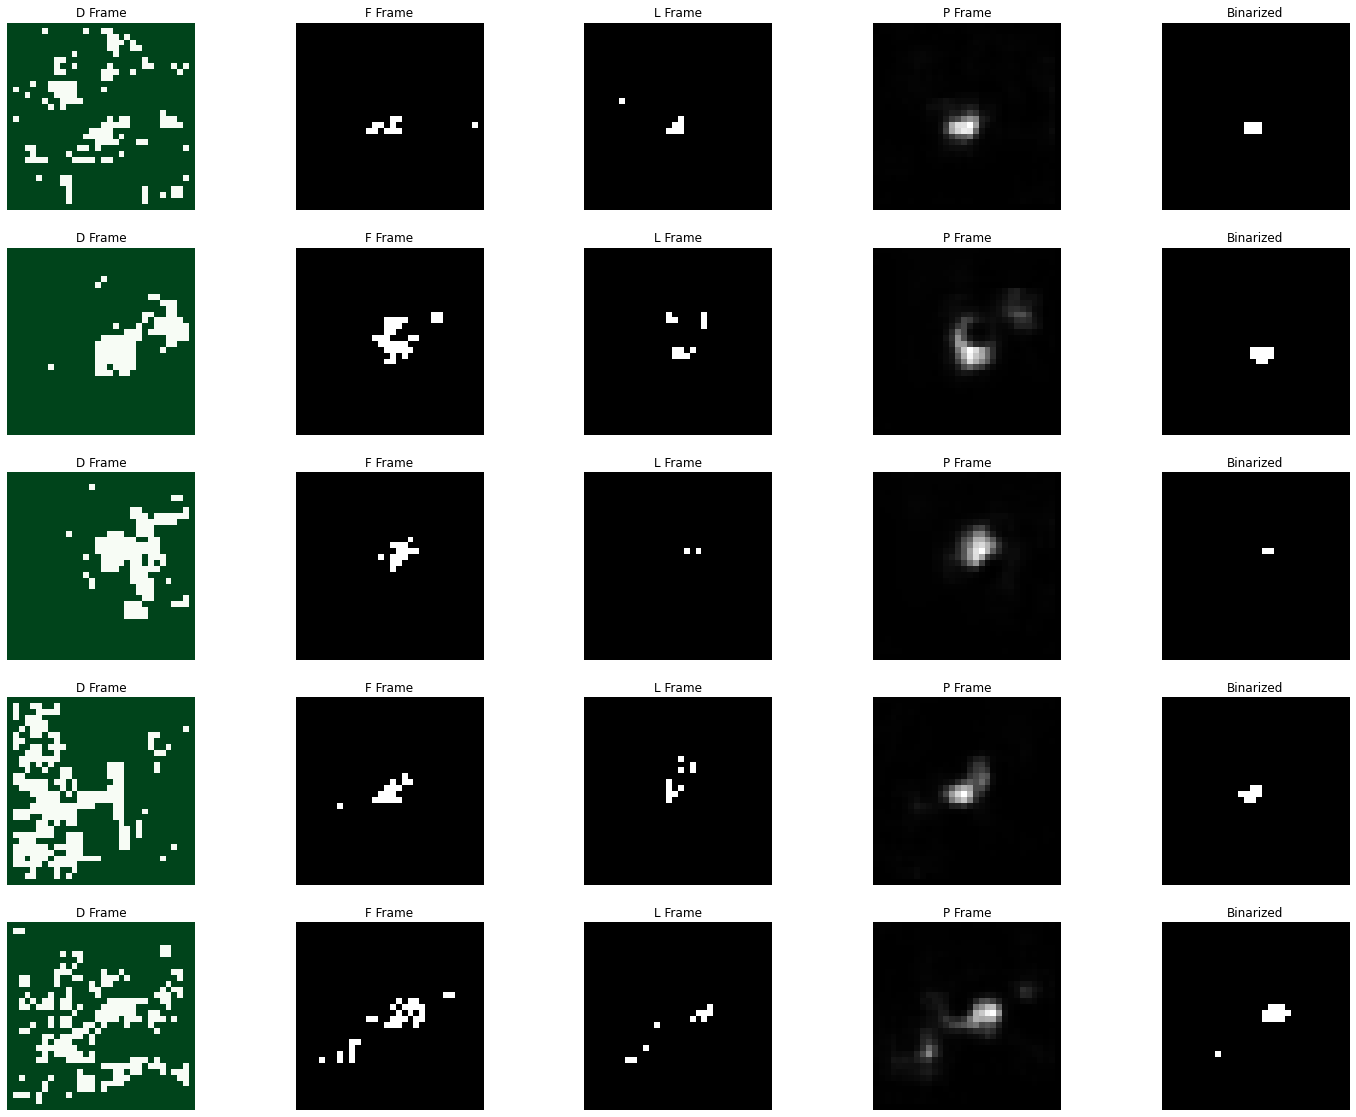

In [42]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(5, 5, figsize=(25, 20))

# List of samples to check:
tgts = [1680, 237, 878, 1325, 1115]
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title(f"D Frame")
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title(f"F Frame")
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title(f"L Frame")
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title(f"P Frame")
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.4, 1, 0)), cmap="gray")
    axes[4].set_title(f"Binarized")
    axes[4].axis("off")

# Display the figure.
plt.show()

### Examining Pretty Bad Predictions

In [44]:
iou_df[iou_df[8] > 0.02][8].sort_values()

654     0.020833
170     0.024390
617     0.026316
1137    0.027027
802     0.027778
812     0.027778
729     0.030303
663     0.031250
655     0.035714
210     0.036364
670     0.038462
1008    0.039474
1386    0.042553
167     0.047619
1019    0.048780
1746    0.048780
983     0.052632
1286    0.055556
713     0.062500
394     0.064516
1337    0.066667
427     0.071429
586     0.081081
1554    0.085714
825     0.086957
739     0.090909
482     0.090909
1338    0.090909
979     0.093750
1643    0.100000
543     0.103448
1254    0.111111
503     0.125000
1209    0.125000
857     0.133333
1418    0.142857
1427    0.142857
1716    0.142857
1889    0.142857
1707    0.156250
131     0.156250
452     0.166667
1866    0.200000
1454    0.200000
1795    0.206897
676     0.235294
837     0.235294
339     0.241379
509     0.250000
1602    0.250000
203     0.250000
154     0.266667
1115    0.277778
1325    0.285714
878     0.333333
237     0.375000
1680    0.625000
Name: 8, dtype: float64

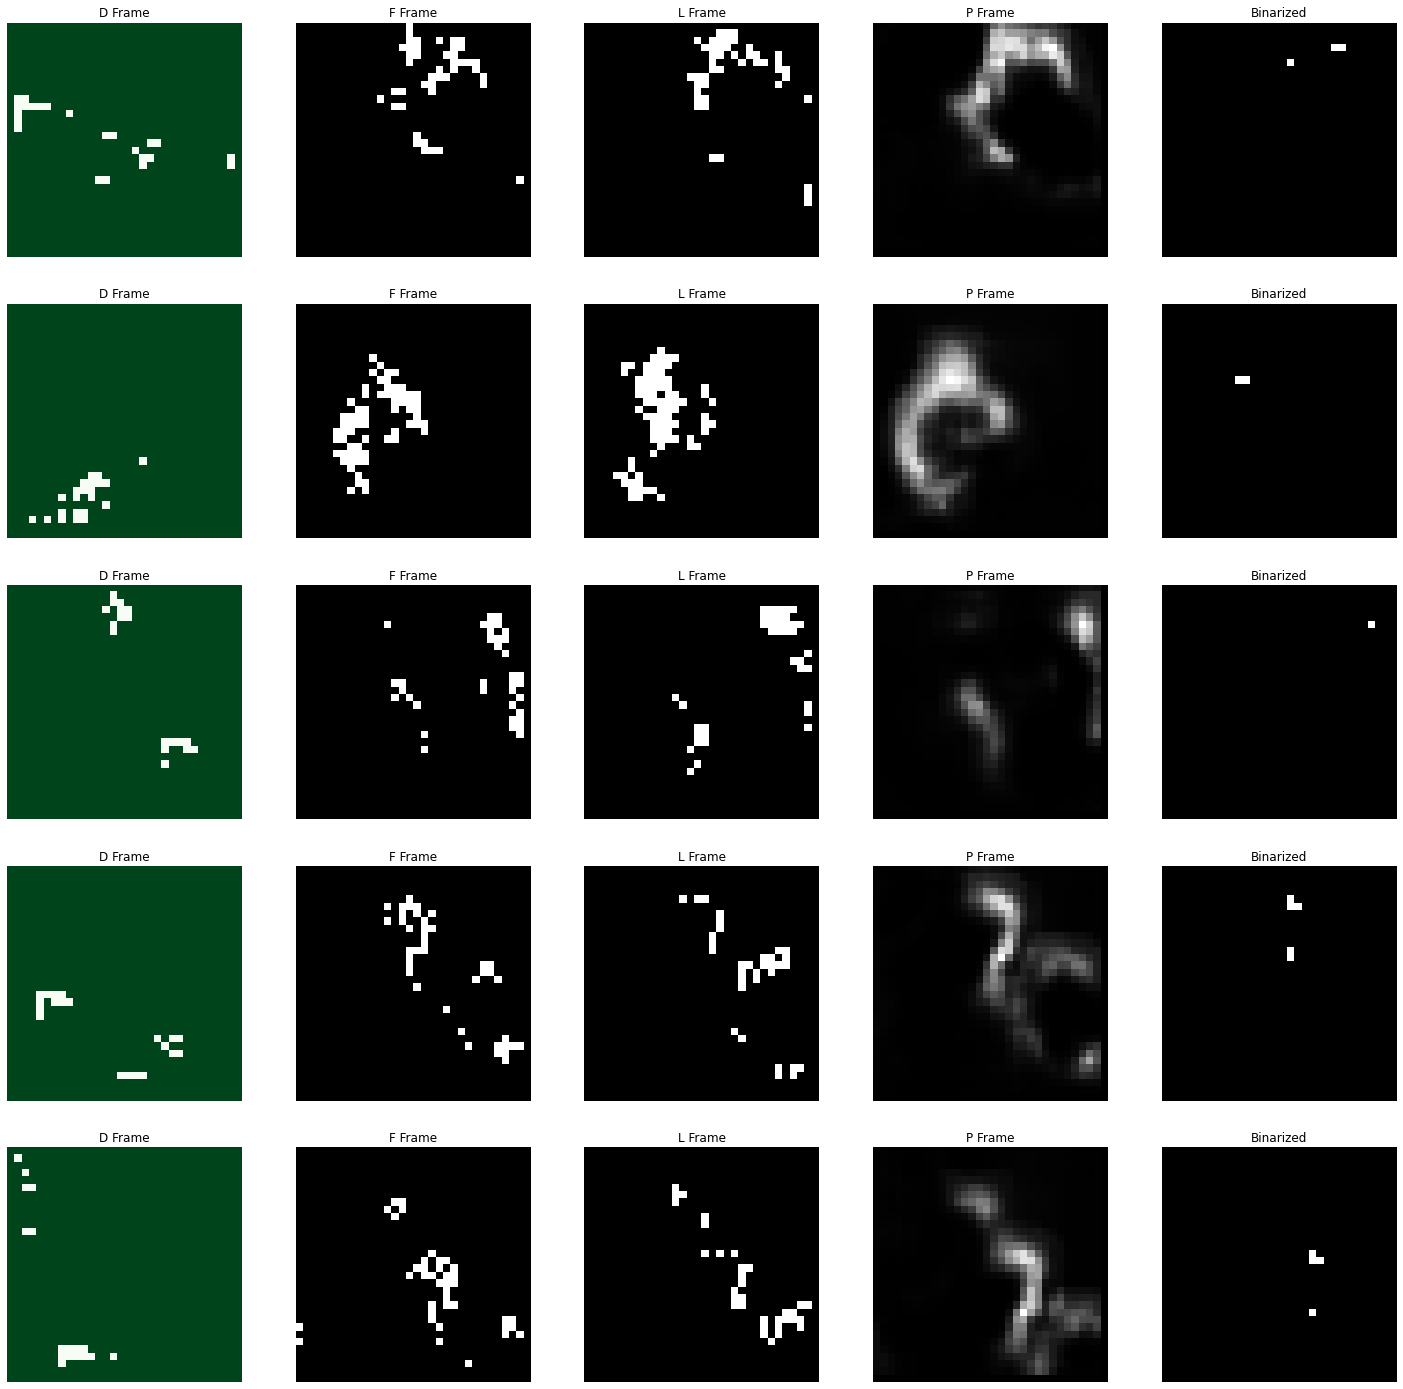

In [46]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(5, 5, figsize=(25, 25))

# List of samples to check:
tgts = [654, 170, 617, 1137, 802]
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title(f"D Frame")
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title(f"F Frame")
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title(f"L Frame")
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title(f"P Frame")
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.4, 1, 0)), cmap="gray")
    axes[4].set_title(f"Binarized")
    axes[4].axis("off")

# Display the figure.
plt.show()